The goal of this notebook is to compare performance of Naive Bayes, SVC (linear kernel), and Logistic Regression (with regularization) classifiers with a bag-of-words (BOW) approach to classify emails as spam or non-spam only using the email text.

Note: this notebook (specifically the cells where models are fit) takes a long time to run because
1. Each model is tuned with cross-validation
2. The data is high-dimensional
3. 3 models are fit each time

First import the relevant packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For ROC Curves
import random as rand
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

Read in data. The data is simply a table with the email text as the sole predictor and the label regarding spam.

In [2]:
spam_data = pd.read_csv('C:/local/data_sets/coursera_data/applied_ds_in_py_spec/spam.csv')
spam_data['target'] = np.where(spam_data['target']=='spam',1,0)

rand.seed(111)
X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)

print(spam_data.shape)
print(spam_data.head())

(5572, 2)
                                                text  target
0  Go until jurong point, crazy.. Available only ...       0
1                      Ok lar... Joking wif u oni...       0
2  Free entry in 2 a wkly comp to win FA Cup fina...       1
3  U dun say so early hor... U c already then say...       0
4  Nah I don't think he goes to usf, he lives aro...       0


First some data exploration.

In [3]:
# What % of data are spam?
spam_data['target'].value_counts().loc[1]/spam_data.shape[0]*100

13.406317300789663

In [4]:
# What is the longest token in the set of emails?
max(CountVectorizer().fit(X_train).get_feature_names(), key=len)

'com1win150ppmx3age16subscription'

First, fit a CountVectorizer object to the training data. A CountVectorizer records the set of all words present in the training data, and can then transform raw text data D to a matrix where each column is an indicator for whether a particular word from the training data set appears in each observation in D.

Then fit each of the 3 classifiers where each predictor indicates whether a word (in the set of words contained in the entire set of emails) appears in a particular email. This is the bag-of-words approach. 

Generally, Naive Bayes models, although making the simplistic assumption that the occurence of any 2 different words is independent, often provide strong models. SVMs are generally a good choice for text data because they work well with high-dimensionality, and typically linear and quadratic kernels are good choices for text data.


The ROC curve of each model is plotted.

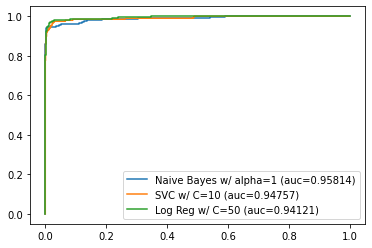

In [5]:
# Fit each classifier w/ tuning parameters chosen by CV
# Plot ROC curves
CountVect = CountVectorizer().fit(X_train)
X_train_mat = CountVect.transform(X_train)
X_test_mat = CountVect.transform(X_test)

rand.seed(0)
mnb = GridSearchCV(MultinomialNB(), 
                   param_grid={'alpha':[.01,.05,.1,.25,.5,1]}
                  ).fit(X_train_mat, y_train)
mnb_proba = mnb.predict_proba(X_test_mat)[:,1]
mnb_fpr, mnb_tpr, _ = roc_curve(y_test, mnb_proba)
mnb_auc = roc_auc_score(y_test, mnb.predict(X_test_mat))

rand.seed(1)
svc = GridSearchCV(SVC(kernel='linear', probability=True), 
                   param_grid={'C':[1,10,100,1000,10000]}
                  ).fit(X_train_mat, y_train)
svc_proba = svc.predict_proba(X_test_mat)[:,1]
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_proba)
svc_auc = roc_auc_score(y_test, svc.predict(X_test_mat))

rand.seed(2)
log = GridSearchCV(LogisticRegression(), 
                   param_grid={'C':[1,5,10,50]}
                  ).fit(X_train_mat, y_train)
log_proba = log.predict_proba(X_test_mat)[:,1]
log_fpr, log_tpr, _ = roc_curve(y_test, log_proba)
log_auc = roc_auc_score(y_test, log.predict(X_test_mat))

fig, ax = plt.subplots()
ax.plot(mnb_fpr, mnb_tpr, 
        label='Naive Bayes w/ alpha={} (auc={})'.format(mnb.best_params_['alpha'],
                                                           round(mnb_auc,5))
       )
ax.plot(svc_fpr, svc_tpr, 
        label='SVC w/ C={} (auc={})'.format(svc.best_params_['C'],
                                                           round(svc_auc,5))
       )
ax.plot(log_fpr, log_tpr, 
        label='Log Reg w/ C={} (auc={})'.format(log.best_params_['C'],
                                                           round(log_auc,5))
       )
plt.legend()
plt.show()

Trying to improve on the previous models, let's convert the data into Term Frequency Inverse Document Frequency (TDIDF) format. For each word in the training set, a TFIDF vectorizer records that word's frequency in each document, and also the percentage of documents that word appears in. Words like 'the' which appear in virtually every document with a high frequency will have a low TFIDF, whereas words which appear only in a few documents but frequently occur in those will have a high TFIDF: this is desirable since words like 'the' are uninformative, but words which appear multiple times in only a few documents are probably very informative.

Lowest TFIDFs: 
(sympathetic: 0.074), (healer: 0.074), (aaniye: 0.074), (dependable: 0.074), (companion: 0.074),
(listener: 0.074), (athletic: 0.074), (exterminator: 0.074), (psychiatrist: 0.074), (pest: 0.074),
(determined: 0.074), (chef: 0.074), (courageous: 0.074), (stylist: 0.074), (psychologist: 0.074),
(organizer: 0.074), (pudunga: 0.074), (venaam: 0.074), (diwali: 0.091), (mornings: 0.091),


Highest TFIDFs
(146tf150p: 1.0), (havent: 1.0), (home: 1.0), (okie: 1.0), (thanx: 1.0),
(er: 1.0), (anything: 1.0), (lei: 1.0), (nite: 1.0), (yup: 1.0),
(thank: 1.0), (ok: 1.0), (where: 1.0), (beerage: 1.0), (anytime: 1.0),
(too: 1.0), (done: 1.0), (645: 1.0), (tick: 0.98), (blank: 0.933),



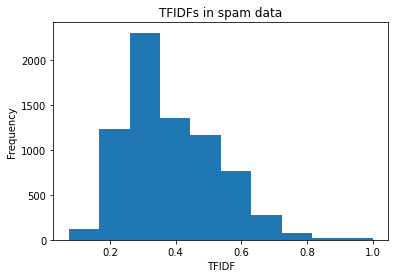

In [6]:
tfidf_v = TfidfVectorizer().fit(X_train)
features = np.array(tfidf_v.get_feature_names())

X_train_mat = tfidf_v.transform(X_train)

# Get the maximal TFIDF for each word since TFIDFs
# for most word, doc pairs will be 0 since most words are likely to not appear in most documents
tfidf_max = X_train_mat.max(0).toarray()[0]
tfidf_max_argsor = tfidf_max.argsort()

# 20 words with lowest TFIDF
print('Lowest TFIDFs: ')
print(''.join(['({}: {}),{}'.format(features[a],
                                   round(tfidf_max[a],3),
                                   ' ' if (i+1)%5!=0 else '\n') 
               for i, a in enumerate(tfidf_max_argsor[:20])]))

# 20 words with highest TFIDF
print('\nHighest TFIDFs')
print(''.join(['({}: {}),{}'.format(features[a],
                                   round(tfidf_max[a],3),
                                   ' ' if (i+1)%5!=0 else '\n') 
               for i, a in enumerate(tfidf_max_argsor[:-21:-1])]))

# Plot histogram of word TFIDFs in dataset
fig, ax = plt.subplots()
ax.hist(tfidf_max)
ax.set_xlabel('TFIDF')
ax.set_ylabel('Frequency')
plt.title('TFIDFs in spam data')
plt.show()

Now let's fit each model with word TFIDFs, where each word has a document frequency of at least 5 (an arbitrary threshold). We'll skip plotting the ROC curve since the AUC is large. We'll aslo supress ConvergenceWarning so out output looks nice.

In [13]:
tfidf_vec = TfidfVectorizer(min_df=5).fit(X_train)
X_train_mat = tfidf_vec.transform(X_train)
X_test_mat = tfidf_vec.transform(X_test)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

rand.seed(4)
mnb = GridSearchCV(MultinomialNB(), 
                 param_grid={'alpha':[.1,.25,.5,1]}
                ).fit(X_train_mat, y_train)
svc = GridSearchCV(SVC(kernel='linear'), 
                   param_grid={'C':[1,10,1000,10000]}
                  ).fit(X_train_mat, y_train)
log = GridSearchCV(LogisticRegression(),
                  param_grid={'C':[1,10,50,100]}
                  ).fit(X_train_mat, y_train)

print('Multinomial Naive Bayes (alpha = {}) with TFIDF:'.format(mnb.best_params_['alpha']))
print(roc_auc_score(y_test, mnb.predict(X_test_mat)))
print('SVC (C = {}) with TFIDF:'.format(svc.best_params_['C']))
print(roc_auc_score(y_test, svc.predict(X_test_mat)))
print('LogReg (C = {}) with TFIDF:'.format(log.best_params_['C']))
print(roc_auc_score(y_test, log.predict(X_test_mat)))

Multinomial Naive Bayes (alpha = 0.1) with TFIDF:
0.9412063052815646
SVC (C = 1) with TFIDF:
0.9505224691441863
LogReg (C = 100) with TFIDF:
0.9577186221414868


When using TFIDFs, we get a lower AUC for Naive Bayes but a higher AUC for SVC and Logsitic Regression. 

Let's see if adding other variables to our TFIDF models improves them. A natural choice is the length of spam emails vs. non-spam emails.

In [14]:
print('Mean length of non-spam emails: {}'.format(spam_data[spam_data['target']==0]['text'].map(len).mean()))
print('Mean length of spam emails: {}'.format(spam_data[spam_data['target']==1]['text'].map(len).mean()))

Mean length of non-spam emails: 71.02362694300518
Mean length of spam emails: 138.8661311914324


In [15]:
# Helper function to add features to a sparse (csr) matrix
def add_feature(X, feature_to_add):
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

Now let's fit each model on the TFIDF data (where each word has a document frequency of at least 5) , and the length of the string. We'll change the SVC kernel to radial to reduce computation.

In [16]:
tfidf_vec = TfidfVectorizer(min_df=5).fit(X_train)
X_train_mat = tfidf_vec.transform(X_train)
X_test_mat = tfidf_vec.transform(X_test)
X_train_mat=add_feature(X_train_mat, X_train.map(len))
X_test_mat=add_feature(X_test_mat, X_test.map(len))

rand.seed(5)
mnb=GridSearchCV(MultinomialNB(), 
                 param_grid={'alpha':[.01,.05,.1,.25,.5,1]}
                ).fit(X_train_mat, y_train)
svc = GridSearchCV(SVC(), 
                   param_grid={'C':[1,10,100,1000,10000]}
                  ).fit(X_train_mat, y_train)
log = GridSearchCV(LogisticRegression(),
                  param_grid={'C':[1,10,50,100]}
                  ).fit(X_train_mat, y_train)

print('Multinomial Naive Bayes (alpha = {}) with TFIDF:'.format(mnb.best_params_['alpha']))
print(roc_auc_score(y_test, mnb.predict(X_test_mat)))
print('SVC (C = {}) with TFIDF:'.format(svc.best_params_['C']))
print(roc_auc_score(y_test, svc.predict(X_test_mat)))
print('LogReg (C = {}) with TFIDF:'.format(log.best_params_['C']))
print(roc_auc_score(y_test, log.predict(X_test_mat)))

Multinomial Naive Bayes (alpha = 0.25) with TFIDF:
0.9412063052815646
SVC (C = 10000) with TFIDF:
0.9661689557407943
LogReg (C = 50) with TFIDF:
0.9615405836714598


Let's now add variables containing how many digits are in each document, variables for n-grams 2-5 of each document, and a variable recording how many non-alphanumeric characters are contained in each document.

In [17]:
# Find average number of digits in non-spam and spam emails
print('Mean # digits in non-spam email: {}'
      .format(spam_data[spam_data['target']==0]['text'].map(lambda x: sum(c.isdigit() for c in x)).mean()))
print('Mean # digits in spam email: {}'
      .format(spam_data[spam_data['target']==1]['text'].map(lambda x: sum(c.isdigit() for c in x)).mean()))

# Get the average # of non-word characters in non-spam and spam emails
def non_word_char(c):
        return 1-int(c.isalpha() or c.isdigit() or c=='_')

print('\nMean # non-word characters in non-spam emails: {}'
      .format(spam_data[spam_data['target']==0]['text'].map(lambda s: sum(non_word_char(c) for c in s)).mean()))
print('Mean # non-word characters in spam emails: {}'
      .format(spam_data[spam_data['target']==1]['text'].map(lambda s: sum(non_word_char(c) for c in s)).mean()))

Mean # digits in non-spam email: 0.2992746113989637
Mean # digits in spam email: 15.759036144578314

Mean # non-word characters in non-spam emails: 17.29181347150259
Mean # non-word characters in spam emails: 29.042838018741634


In this notebook, we've observed Naive Bayes performing better on CountVectorized data, whereas SVC and LogisticRegression perform better on TFIDFVectorized data.

In [19]:
CountVect = CountVectorizer(min_df=5, ngram_range=(2,5), analyzer='char_wb').fit(X_train)
X_train_mat_cv = CountVect.transform(X_train)
X_test_mat_cv = CountVect.transform(X_test)

tfidf_v = TfidfVectorizer(min_df=5, ngram_range=(2,5), 
                          analyzer='char_wb').fit(X_train)
X_train_mat_tfidf = tfidf_v.transform(X_train)
X_test_mat_tfidf = tfidf_v.transform(X_test)

# Add length of each document
X_train_mat_cv=add_feature(X_train_mat_cv, X_train.map(len))
X_test_mat_cv=add_feature(X_test_mat_cv, X_test.map(len))

X_train_mat_tfidf=add_feature(X_train_mat_tfidf, X_train.map(len))
X_test_mat_tfidf=add_feature(X_test_mat_tfidf, X_test.map(len))

# Add # digits in each document
X_train_mat_cv = add_feature(X_train_mat_cv, 
                             X_train.map(lambda s: sum(c.isdigit() for c in s))) 
X_test_mat_cv = add_feature(X_test_mat_cv, 
                            X_test.map(lambda s: sum(c.isdigit() for c in s)))

X_train_mat_tfidf = add_feature(X_train_mat_tfidf, 
                                X_train.map(lambda s: sum(c.isdigit() for c in s))) 
X_test_mat_tfidf = add_feature(X_test_mat_tfidf, 
                               X_test.map(lambda s: sum(c.isdigit() for c in s)))

# Add # of non-alphanumeric characters in each document
X_train_mat_cv = add_feature(X_train_mat_cv, 
                             X_train.map(lambda s: sum(non_word_char(c) for c in s)))
X_test_mat_cv = add_feature(X_test_mat_cv, 
                            X_test.map(lambda s: sum(non_word_char(c) for c in s)))

X_train_mat_tfidf = add_feature(X_train_mat_tfidf, 
                                X_train.map(lambda s: sum(non_word_char(c) for c in s)))
X_test_mat_tfidf = add_feature(X_test_mat_tfidf, 
                               X_test.map(lambda s: sum(non_word_char(c) for c in s)))

rand.seed(6)
mnb = mnb=GridSearchCV(MultinomialNB(), 
                       param_grid={'alpha':[.01,.05,.1,.25,.5,1]}).fit(X_train_mat_cv, y_train)
print('Naive Bayes w/ alpha={}: {}'.format(mnb.best_params_['alpha'],
                                           roc_auc_score(y_test, mnb.predict(X_test_mat_cv))))

log = GridSearchCV(LogisticRegression(), 
                   param_grid={'C':[1,10,100]}).fit(X_train_mat_tfidf, y_train)
print('LogReg w/ C={}: {}'.format(log.best_params_['C'], 
                                  roc_auc_score(y_test, log.predict(X_test_mat_tfidf))))

svc = GridSearchCV(SVC(kernel='linear'),
                  param_grid={'C':[1,10,100,1000,10000]}).fit(X_train_mat_tfidf, y_train)
print('SVC w/ C={}: {}'.format(log.best_params_['C'], 
                               roc_auc_score(y_test, svc.predict(X_test_mat_tfidf))))

Naive Bayes w/ alpha=0.1: 0.9818451521993787
LogReg w/ C=100: 0.9805612617353955
SVC w/ C=100: 0.9771870702680677
